In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import entropy
from matplotlib.collections import LineCollection
from sklearn.metrics import RocCurveDisplay
from pycaret.anomaly import *
from sklearn.preprocessing import MinMaxScaler

In [10]:
data = pd.read_csv('ics_raw_set.csv')
# attack = data[['time', 'attack']].copy()
# data = data.drop(['attack'],axis = 1)
col = [col for col in data.columns]
print(col)
print(data.shape)
time = data['time'].unique().shape[0]
print(time)
ics_entropy = np.zeros((time,data.shape[1]))
attack_entropy = np.zeros((time,))

['time', 'eth.src', 'eth.dst', 'ip.src', 'ip.dst', 'ip.len', 'ip.id', 'ip.flags', 'ip.ttl', 'ip.proto', 'tcp.srcport', 'tcp.dstport', 'tcp.seq', 'tcp.ack', 'tcp.hdr_len', 'tcp.flags', 'tcp.window_size', 'tcp.time_delta', 'tcp.time_relative', 'attack']
(529999, 20)
19633


In [11]:
def calc_entropy(value):
    uvalue,counts = np.unique(value, return_counts=True)
    if value.shape[0] > 1:
        return entropy(counts)
    else :
        return -1

def get_entropy(column,i,df):
    temp = df.loc[df['time'] == i]
    return calc_entropy(temp[column])

In [12]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

In [13]:
for i in range(time):
    result = [get_entropy(col[j],i,data) for j in range(1,len(col))]
    if -1 not in result:
        ics_entropy[i,1:] = result
        
ics_entropy = ics_entropy[~np.any(ics_entropy == -1, axis=1)]
ics_entropy = ics_entropy[~np.all(ics_entropy == 0, axis=1)]
attack_entropy = ics_entropy[:,-1]
print(ics_entropy.shape)
        
ics_to_file = pd.DataFrame(ics_entropy)
ics_to_file.columns = col
ics_to_file.to_csv('ics_entropy.csv', index=False)
attack_to_file = pd.DataFrame(attack_entropy)
attack_to_file.columns = ['attack']
attack_to_file.to_csv('ics_attack.csv', index=False)

# ics_entropy = pd.read_csv('ics_entropy.csv')
# ics_entropy = ics_entropy.drop(['ip.flags'],axis=1)
# col = ics_entropy.columns
# ics_entropy = ics_entropy.to_numpy()
# attack_entropy = pd.read_csv('ics_attack.csv').to_numpy()

(19474, 20)


In [14]:
scaler = MinMaxScaler(feature_range=(0, 1))
ics_entropy = scaler.fit_transform(ics_entropy)    
attack_time = np.asarray(np.where(attack_entropy > 0))[0]
print(attack_time)         
            

[ 1012  1013  1014 ... 18562 18563 18564]


In [18]:
smooth_ics = ics_entropy.copy()
for i in range(smooth_ics.shape[1]):
    smooth_ics[:,i] = smooth(smooth_ics[:,i],100)

for j in range(len(smooth_ics[:,-1])):
    if smooth_ics[j,-1] > 0:
        smooth_ics[j,-1] = 1
    
smooth_ics = smooth_ics[100:-100,:]

print(np.unique(smooth_ics[:,-1]))

[0. 1.]


In [19]:
smooth_entropy = smooth_ics[:,-1]
smooth_time = np.asarray(np.where(smooth_entropy > 0))[0]

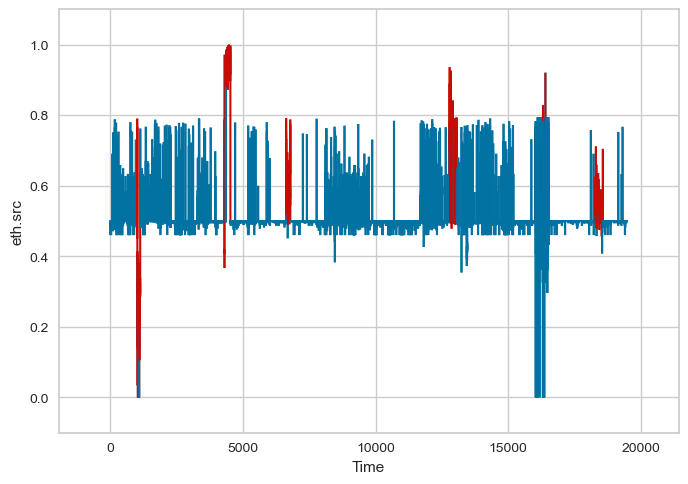

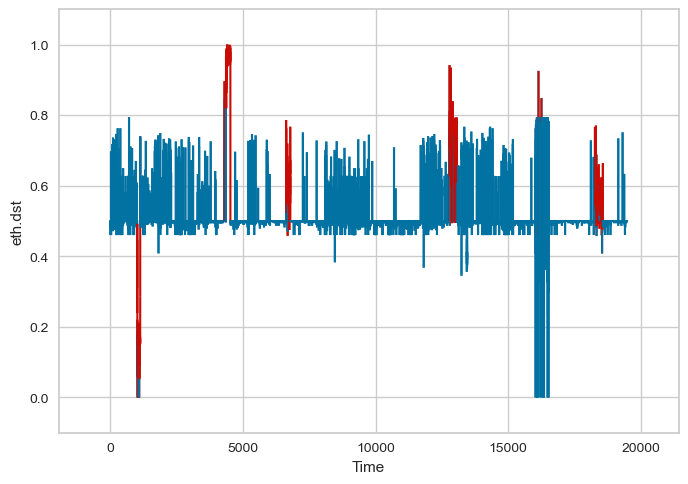

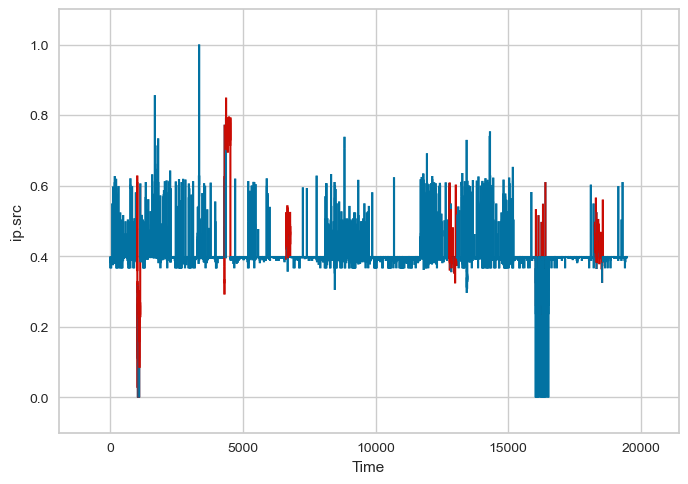

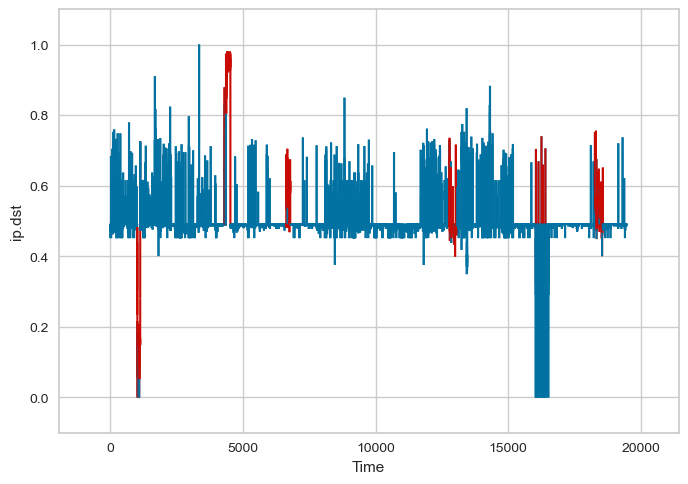

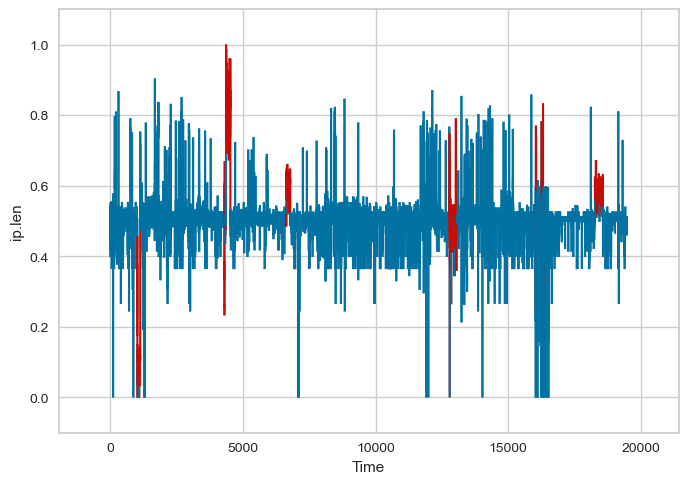

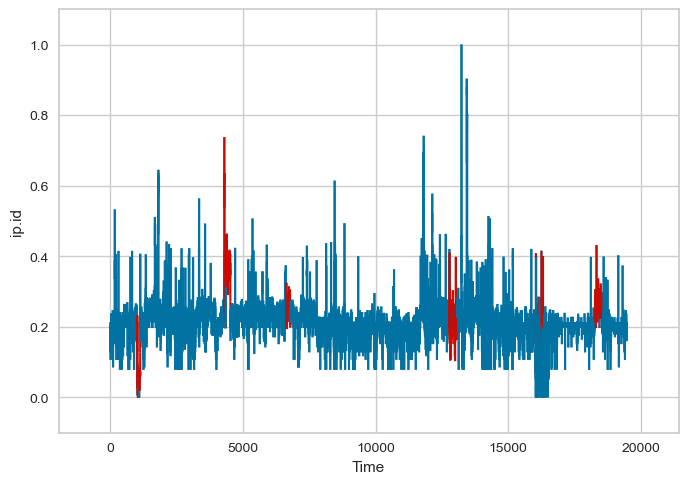

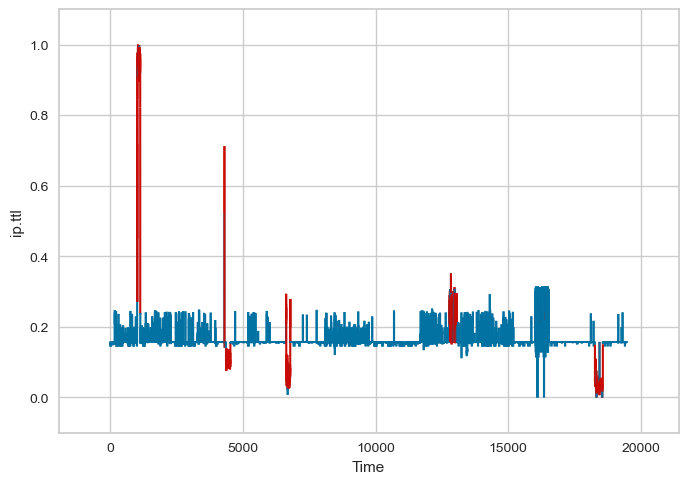

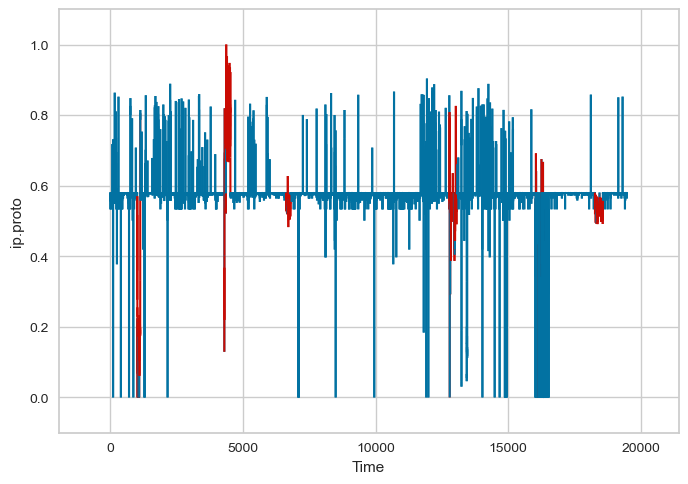

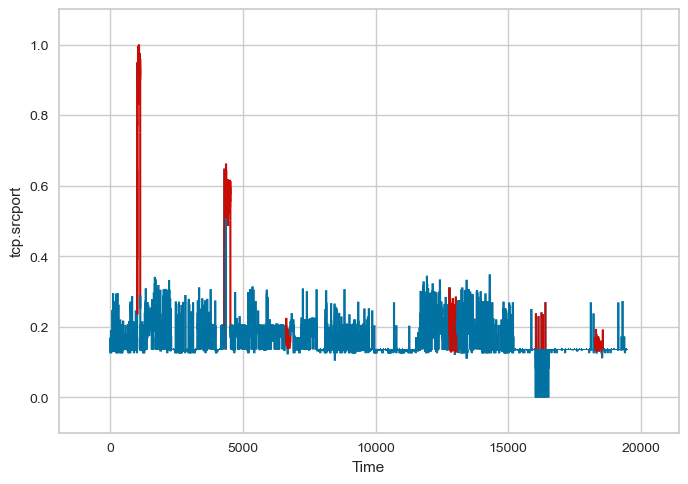

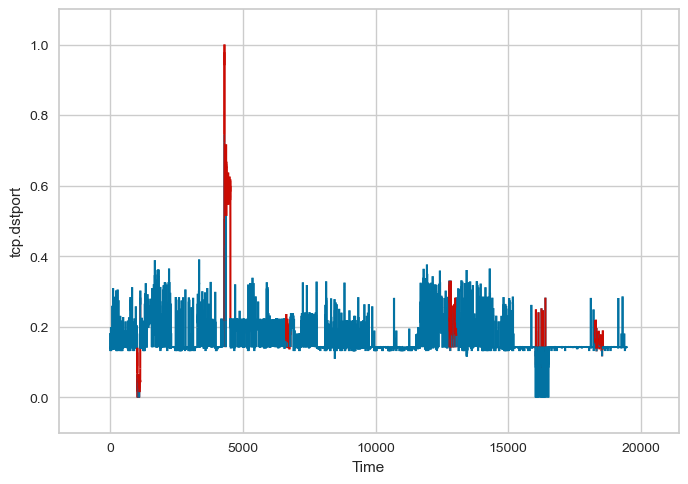

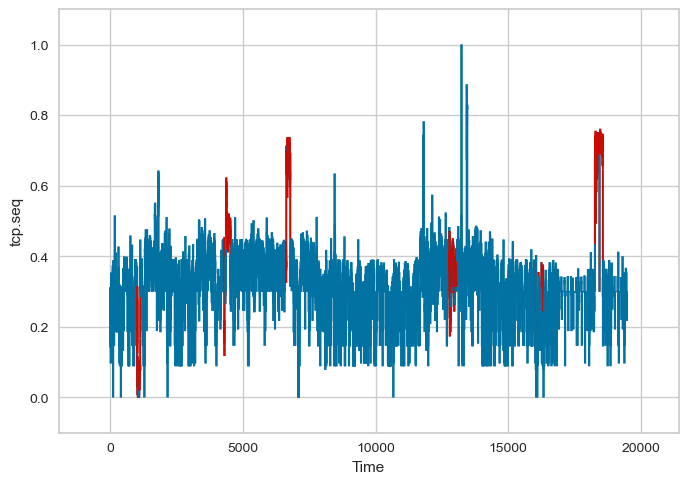

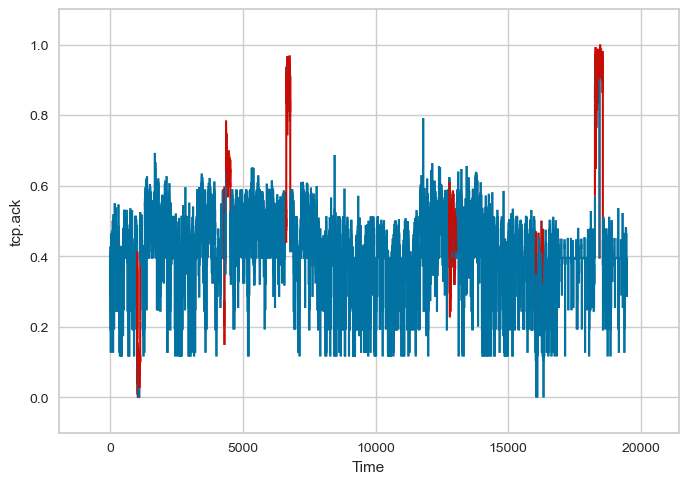

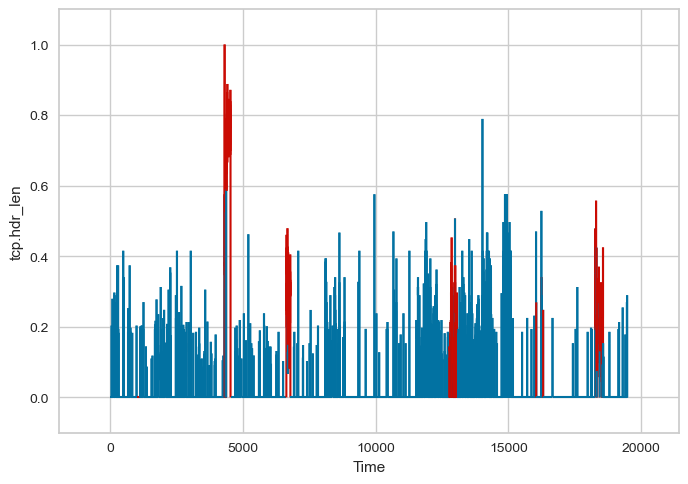

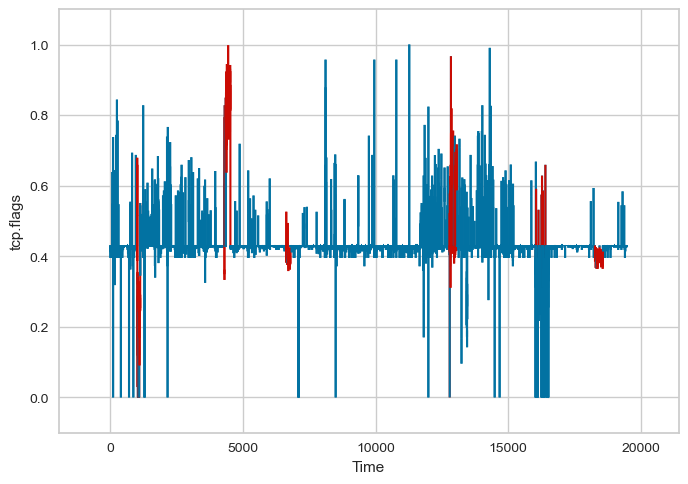

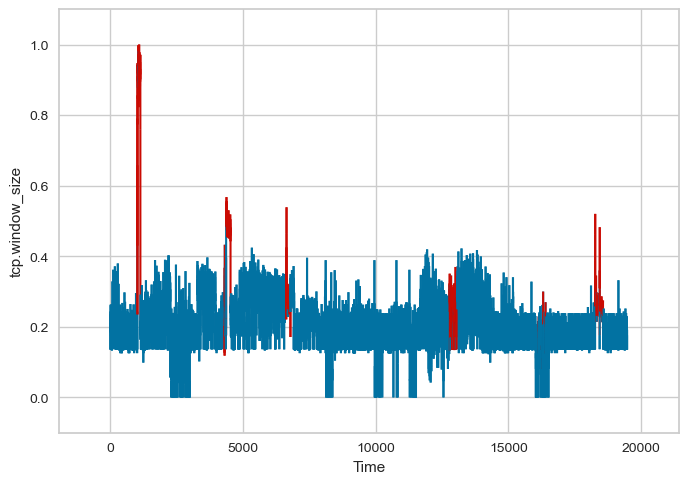

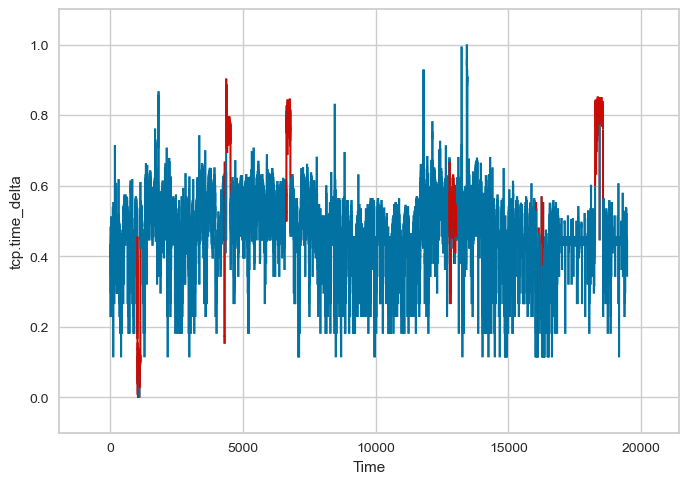

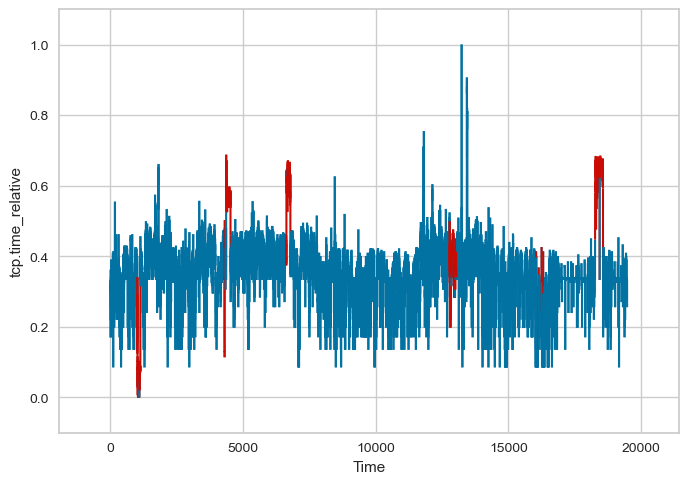

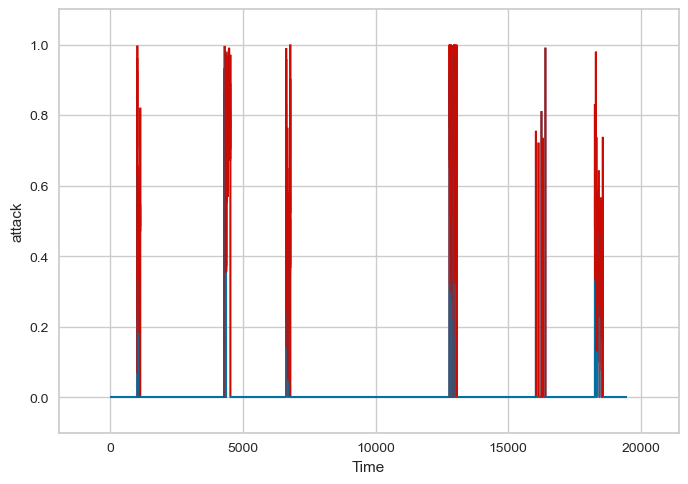

In [20]:
for i in range(1,19):
    x = range(ics_entropy.shape[0])
    y = ics_entropy[:,i]
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    cm = dict(zip(range(0,2,1),list("br")))
    colors = list( map( cm.get , np.isin(x,attack_time) ))

    lc = LineCollection(segments, colors=colors, linewidths=1.5)
    fig, ax = plt.subplots()
    ax.add_collection(lc)

    ax.autoscale()
    ax.margins(0.1)
    plt.xlabel('Time')
    plt.ylabel(col[i])
    plt.show()

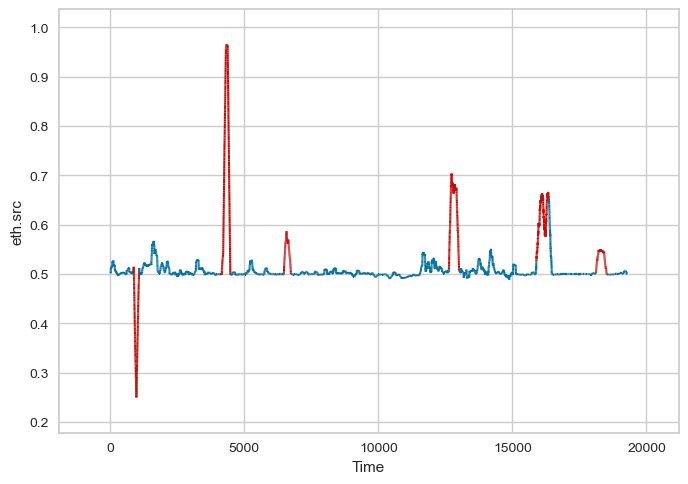

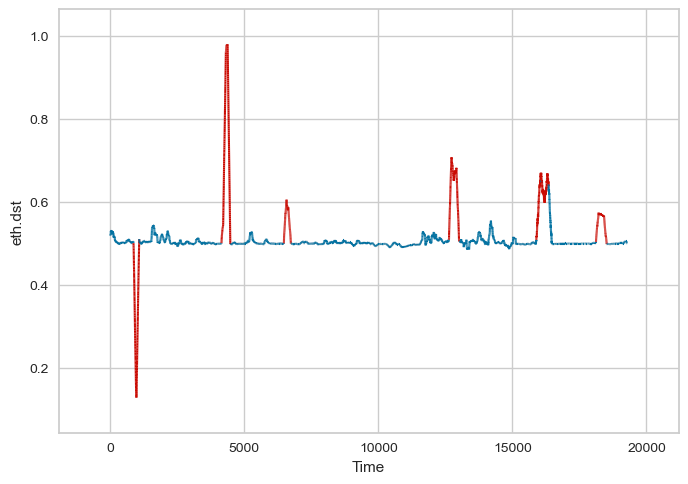

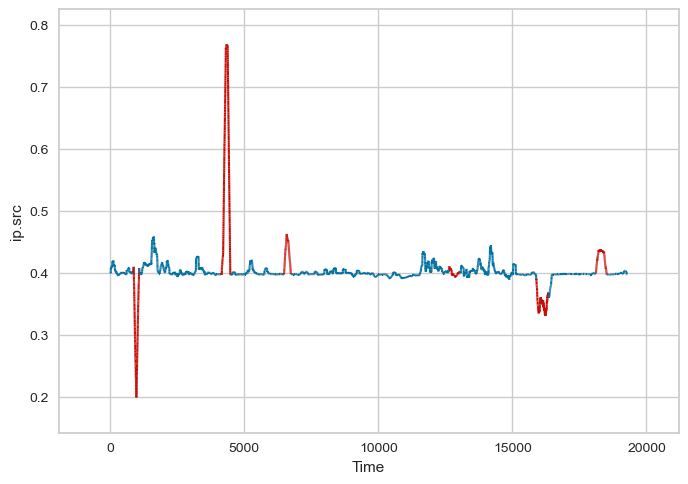

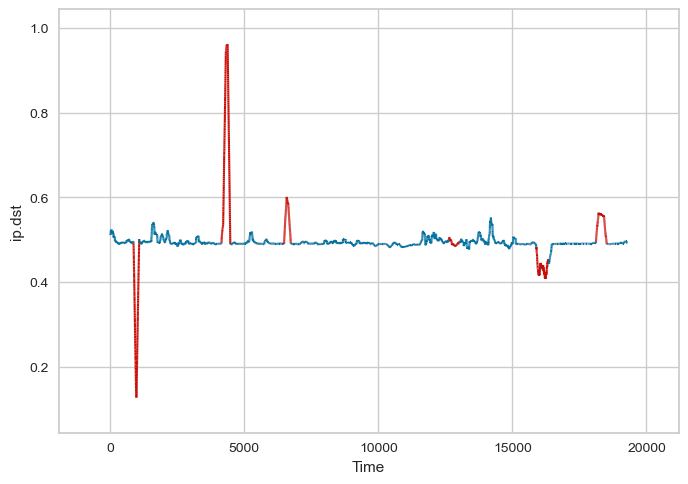

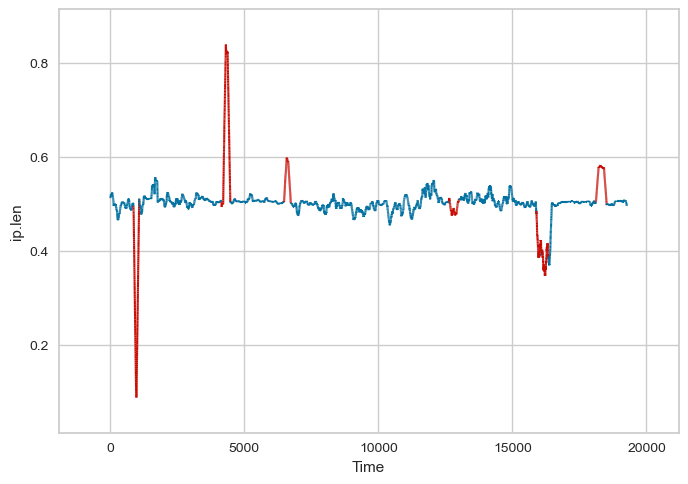

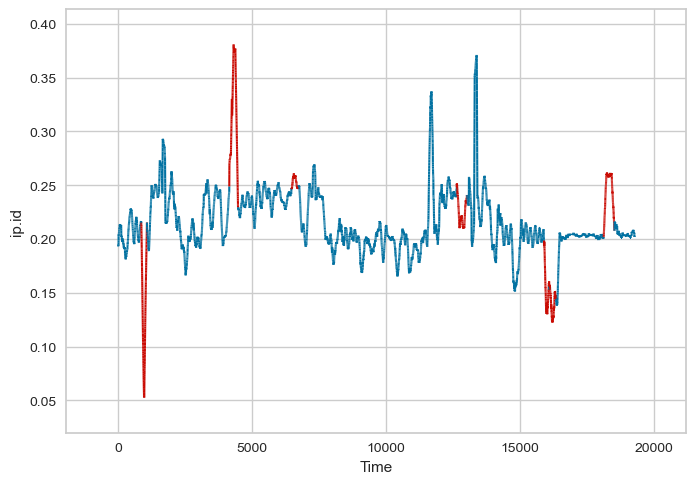

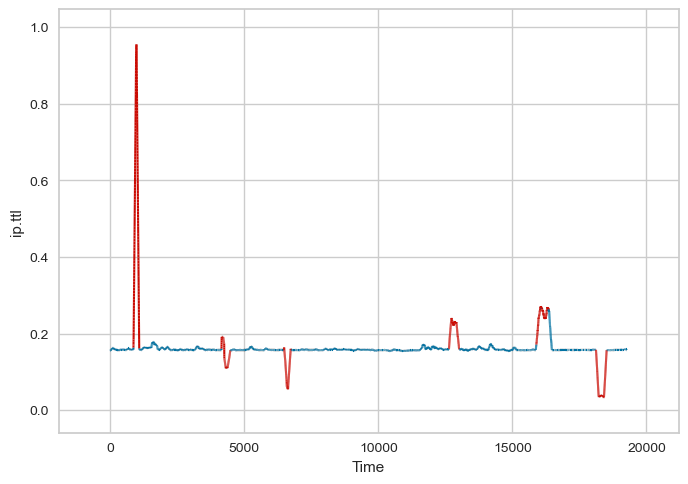

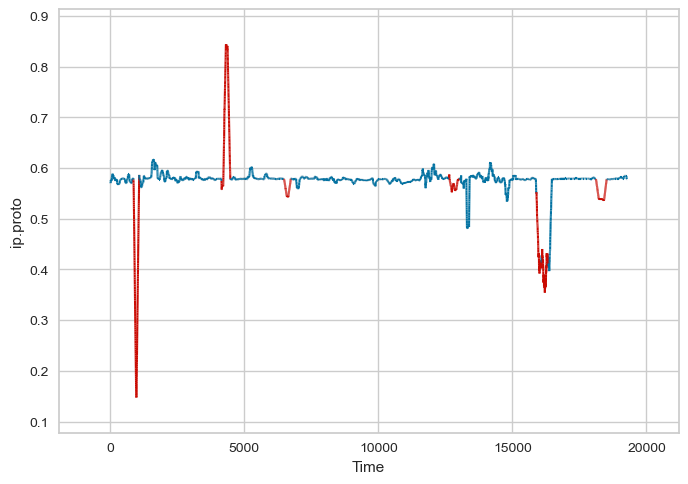

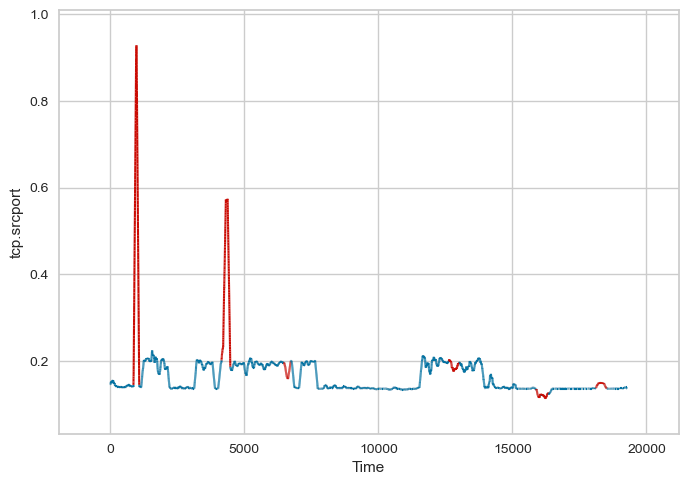

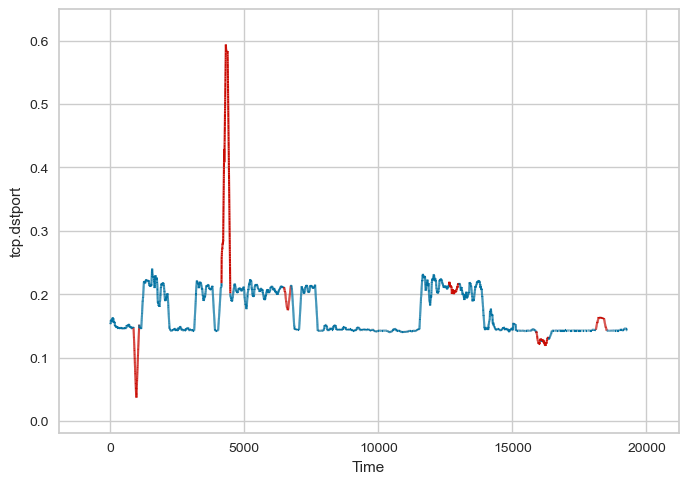

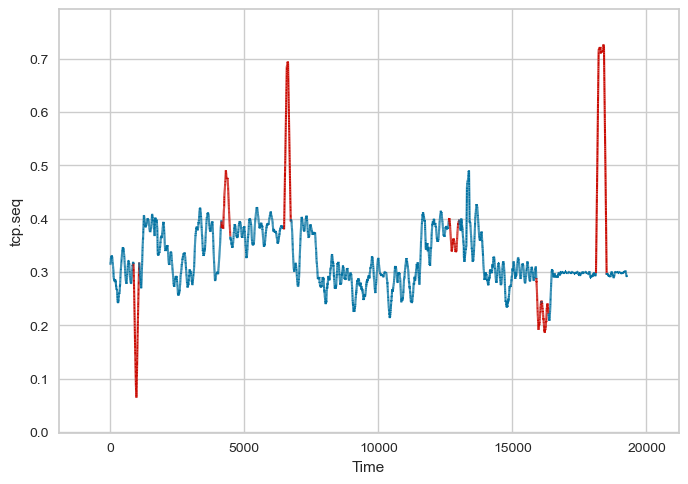

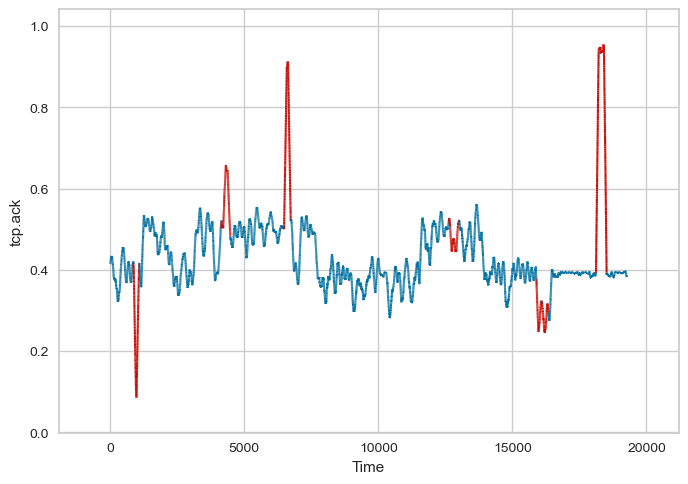

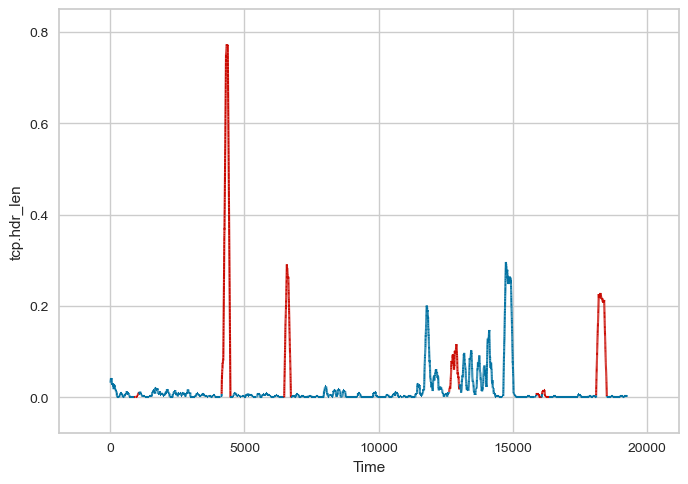

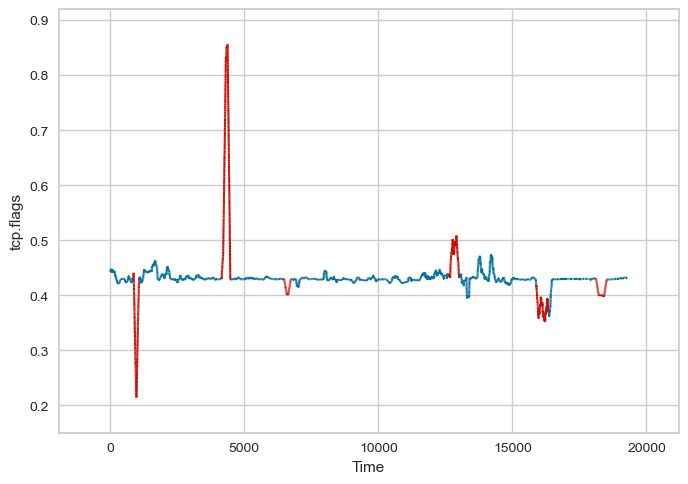

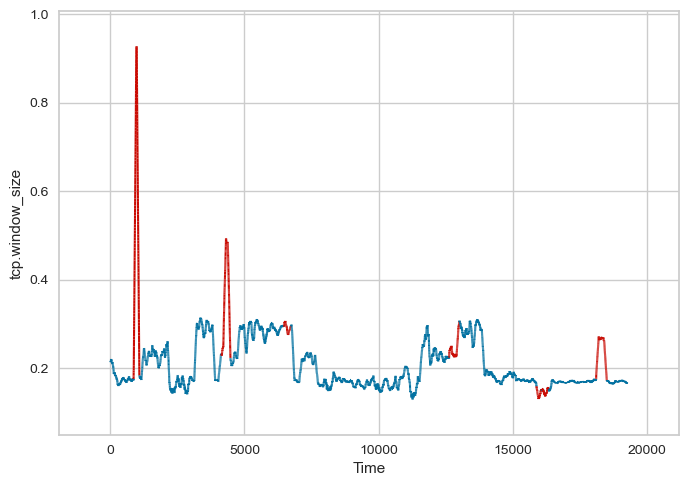

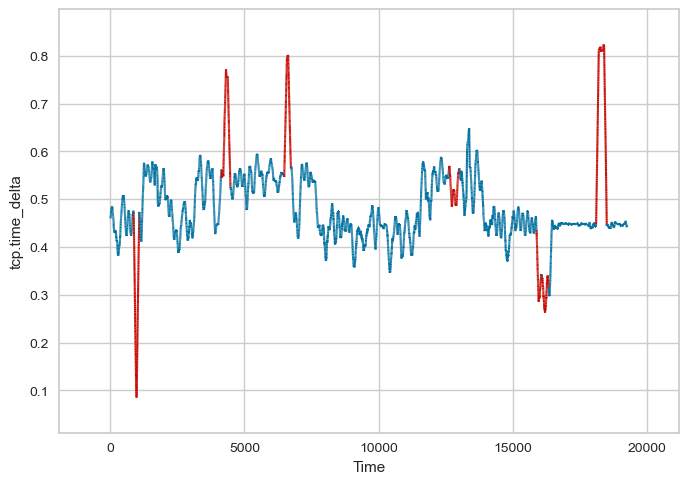

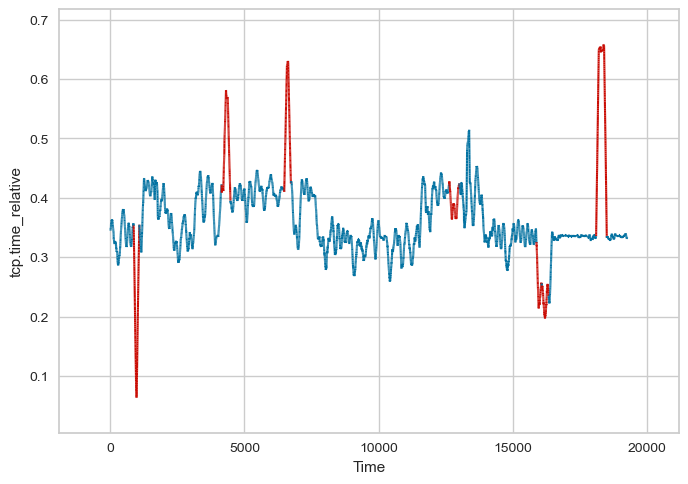

In [21]:
for i in range(1,len(col)-1):
    x = range(smooth_ics.shape[0])
    y = smooth_ics[:,i]
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    cm = dict(zip(range(0,2,1),list("br")))
    colors = list( map( cm.get , np.isin(x,smooth_time) ))

    lc = LineCollection(segments, colors=colors, linewidths=1.5)
    fig, ax = plt.subplots()
    ax.add_collection(lc)

    ax.autoscale()
    ax.margins(0.1)
    plt.xlabel('Time')
    plt.ylabel(col[i])
    plt.show()

In [22]:
X = pd.DataFrame(smooth_ics[:,1:])
# X = pd.DataFrame(ics_entropy)
# X.columns = col[0:-1]
X.columns = col[1:]
# setup(X,session_id=123)
setup(X,target='attack',fix_imbalance = True,feature_selection=True)

,Description,Value
0,session_id,4077
1,Target,attack
2,Target Type,Binary
3,Label Encoded,"0.0: 0, 1.0: 1"
4,Original Data,"(19274, 18)"
5,Missing Values,False
6,Numeric Features,17
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


(None,
 4077,
 {'USI',
  'X',
  'X_test',
  'X_train',
  '_all_metrics',
  '_all_models',
  '_all_models_internal',
  '_available_plots',
  '_gpu_n_jobs_param',
  '_internal_pipeline',
  '_ml_usecase',
  'create_model_container',
  'dashboard_logger',
  'data_before_preprocess',
  'display_container',
  'exp_name_log',
  'experiment__',
  'fix_imbalance_method_param',
  'fix_imbalance_param',
  'fold_generator',
  'fold_groups_param',
  'fold_groups_param_full',
  'fold_param',
  'fold_shuffle_param',
  'gpu_param',
  'html_param',
  'imputation_classifier',
  'imputation_regressor',
  'iterative_imputation_iters_param',
  'log_plots_param',
  'logging_param',
  'master_model_container',
  'n_jobs_param',
  'prep_pipe',
  'pycaret_globals',
  'seed',
  'stratify_param',
  'target_param',
  'transform_target_method_param',
  'transform_target_param',
  'y',
  'y_test',
  'y_train'},
 {'parameter': 'Hyperparameters',
  'auc': 'AUC',
  'confusion_matrix': 'Confusion Matrix',
  'threshold'

In [23]:
# models()
model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.9992,0.9986,0.9942,0.9979,0.9960,0.9956,0.9956,0.0520
rf,Random Forest Classifier,0.9992,0.9999,0.9935,0.9986,0.9960,0.9956,0.9956,1.0050
et,Extra Trees Classifier,0.9992,1.0000,0.9928,0.9993,0.9960,0.9956,0.9956,0.4110
lightgbm,Light Gradient Boosting Machine,0.9992,0.9990,0.9957,0.9964,0.9960,0.9956,0.9956,0.4150
dt,Decision Tree Classifier,0.9981,0.9955,0.9921,0.9900,0.9910,0.9900,0.9900,0.0940
gbc,Gradient Boosting Classifier,0.9977,0.9993,0.9892,0.9886,0.9889,0.9876,0.9876,3.0080
ada,Ada Boost Classifier,0.9960,0.9993,0.9878,0.9741,0.9808,0.9785,0.9786,0.6170
qda,Quadratic Discriminant Analysis,0.9890,0.9968,0.9885,0.9125,0.9487,0.9426,0.9437,0.0250
lr,Logistic Regression,0.9850,0.9858,0.9065,0.9454,0.9254,0.9170,0.9174,0.6520
svm,SVM - Linear Kernel,0.9840,0.0000,0.8978,0.9446,0.9203,0.9114,0.9120,0.0290


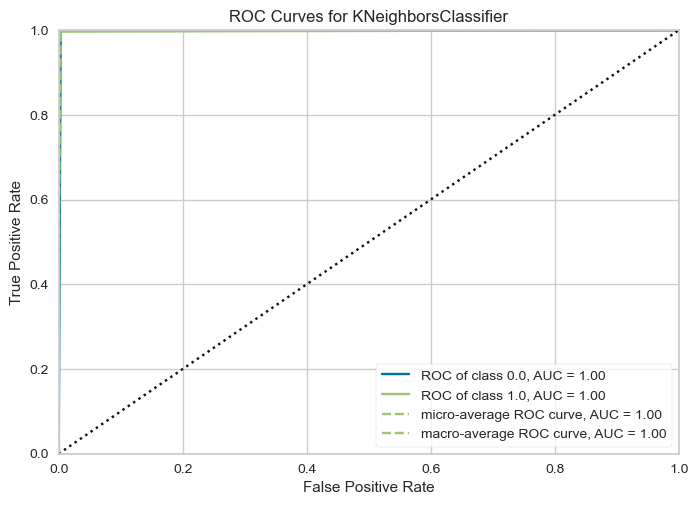

In [24]:
knn = create_model('knn')
# plot_model(gbc, plot = 'feature')
plot_model(knn, plot = 'auc')

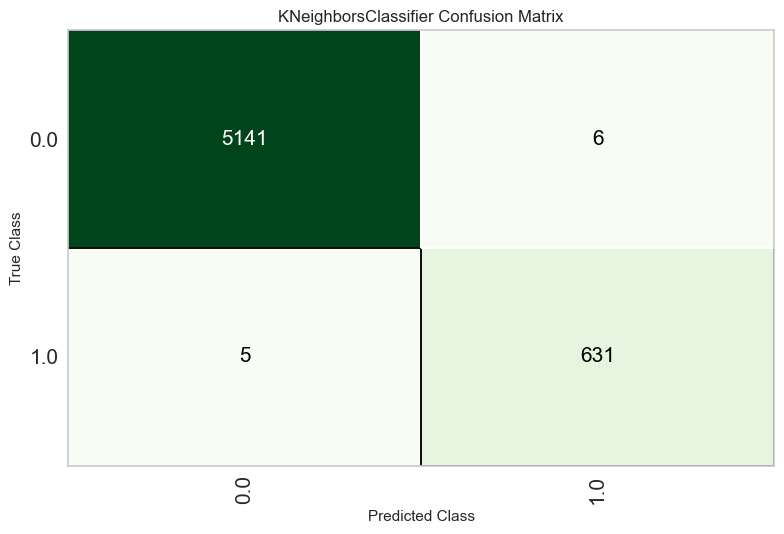

/Users/karnbongkotboonriong/opt/anaconda3/envs/pycaret/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/Users/karnbongkotboonriong/opt/anaconda3/envs/pycaret/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/Users/karnbongkotboonriong/opt/anaconda3/envs/pycaret/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/Users/karnbongkotboonriong/opt/anaconda3/envs/pycaret/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_intercept_ was deprecated in version 0.23 and will be remove

/Users/karnbongkotboonriong/opt/anaconda3/envs/pycaret/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/Users/karnbongkotboonriong/opt/anaconda3/envs/pycaret/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/Users/karnbongkotboonriong/opt/anaconda3/envs/pycaret/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/Users/karnbongkotboonriong/opt/anaconda3/envs/pycaret/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_intercept_ was deprecated in version 0.23 and will be remove

In [26]:
plot_model(knn, plot = 'confusion_matrix')